In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('F:MachineLearning/MachineLearn/ML_Notes-master/ML_Notes-master/')
from ml_models import utils
%matplotlib inline

In [55]:
#定义一个绘制决策边界以及支持向量的函数
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1,X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    #画出支持向量
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', edgecolor='red')

In [56]:
"""
硬间隔支持向量机的smo实现
"""
class HardMarginSVM(object):
    def __init__(self,epochs=100):
        self.w = None
        self.b = None
        self.alpha = None
        self.E = None
        self.support_vectors = None
        self.epochs = epochs
        
    def init_params(self, X, y):
        n_sample, n_feature = X.shape 
        self.w = np.zeros(n_feature)
        self.b = .0
        self.alpha = np.zeros(n_sample)
        self.E = np.zeros(n_sample)
        #初始化E，为预测值与真实值之差
        for i in range(0, n_sample):
            self.E[i] = np.dot(self.w, X[i, :]) + self.b - y[i]
    
    def _select_j(self, best_i):
        """
        选择j
        :param best_i:
        :return best_j:
        """
        valid_j_list = [i for i in range(0, len(self.alpha)) if self.alpha[i]>0 and i!=best_i]
        best_j = -1
        #优先选择\Ei-Ej\最大的 j
        if len(valid_j_list)>0:
            max_e = 0
            for j in valid_j_list:
                current_e = np.abs(self.E[best_i] - self.E[j])
                if current_e > max_e:
                    max_e = current_e
                    best_j = j
        else:
            l = list(range(len(self.alpha)))
            seq = l[: best_i] + l[best_i+1 :]
            best_j = random.choice(seq)
        return best_j
    
    
    def _meet_kkt(self, w, b, x_i, y_i, alpha_i):
        """
        是否满足kkt条件
        :param w:
        :param b:
        :param x_i:
        :param y_i:
        """
        if alpha_i < 1e-7:
            return y_i * (np.dot(w,x_i) + b) >= 1
        else:
            return abs( y_i *(np.dot(w, x_i)+ b ) - 1 ) < 1e-7
        
    def fit(self, X, y2, show_train_process = False):
        """
        :param X:
        :param y2:
        :param show_train_process: 显示训练过程
        :return:
        """
        y = copy.deepcopy(y2)
        y[y == 0] = -1
        self.init_params(X, y)
        for _ in range(0, self.epochs):
            if_all_match_kkt = True
            for i in range(0, len(self.alpha)):
                x_i = X[i,:]
                y_i = y[i]
                alpha_i_old = self.alpha[i]
                E_i_old = self.E[i]
                #选择违反kkt条件的点 i
                if not self._meet_kkt(self.w, self.b, x_i, y_i, alpha_i_old):
                    if_all_match_kkt = False
                    best_j = self._select_j(i)
                    
                    alpha_j_old = self.alpha[best_j]
                    x_j = X[best_j, :]
                    y_j = y[best_j]
                    E_j_old = self.E[best_j]
                    
                    #开始更新
                    # 1.首先获取无裁剪的最优alpha_2
                    eta = np.dot(x_i - x_j, x_i - x_j)
                    if eta< 1e-3:
                        continue
                    alpha_j_unc = alpha_j_old + y_j * (E_i_old - E_j_old) / eta
                    # 2.裁剪得到new alpha_2
                    if y_i == y_j:
                        if alpha_j_unc < 0:
                            alpha_j_new = 0
                        elif 0<= alpha_j_unc <= alpha_i_old + alpha_j_old:
                            alpha_j_new = alpha_j_unc
                        else:
                            alpha_j_new = alpha_i_old + alpha_j_old
                    else:
                        if alpha_j_unc < max(0, alpha_j_old - alpha_i_old):
                            alpha_j_new = max(0, alpha_j_old - alpha_i_old)
                        else:
                            alpha_j_new = alpha_j_unc
                            
                    #变化不够大则跳过
                    if np.abs(alpha_j_new - alpha_j_old) < 1e-5:
                        continue
                    # 3.得到alpha_1_new:
                    alpha_i_new = alpha_i_old + y_i * y_j * (alpha_j_old - alpha_j_new)
                    # 4.更新w:
                    self.w = self.w + (alpha_i_new - alpha_i_old) * y_i * x_i + (alpha_j_new - alpha_j_old) * y_j * x_j
                    # 5.更新alpha_1,alpha_2
                    self.alpha[i] = alpha_i_new
                    self.alpha[best_j] = alpha_j_new
                    # 6.更新b
                    b_i_new = y_i - np.dot(self.w, x_i)
                    b_j_new = y_j - np.dot(self.w, x_j)
                    if alpha_i_new > 0:
                        self.b = b_i_new
                    elif alpha_j_new > 0:
                        self.b = b_j_new
                    else:
                        self.b = (b_i_new + b_j_new) / 2.0
                    # 7.更新E
                    for k in range(0,len(self.E)):
                        self.E[k] = np.dot(self.w,X[k,:]) + self.b - y[k]
                    if show_train_process is True:
                        utils.plot_decision_function(X, y2, self, [i, best_j])
                        utils.plt.pause(0.1)
                        utils.plt.clf()
            #所有都满足kkt条件
            if if_all_match_kkt is True:
                break
        #支持向量
        self.support_vectors = np.where(self.alpha > 1e-3)[0]
        # 利用所有的支持向量，更新b
        self.b = np.mean([y[s] - np.dot(self.w, X[s, :]) for s in self.support_vectors.tolist()])
        # 显示最终结果
        if show_train_process is True:
            utils.plot_decision_function(X, y2, self, self.support_vectors)
            utils.plt.show()
            
    def get_params(self):
        return self.w, self.b
    
    def predict_proba(self, x):
        return utils.sigmoid(x.dot(self.w) + self.b)
    
    def predict(self, x):
        proba = self.predict_proba(x)
        return (proba >= 0.5).astype(int)

In [64]:
from sklearn.datasets import make_classification
#生成数据
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1,n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=2.0)

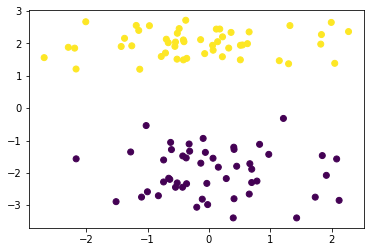

In [65]:
plt.scatter(data[:,0], data[:,1],c=target)

In [66]:
svm = HardMarginSVM()
svm.fit(data, target)

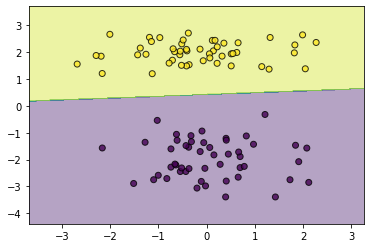

In [67]:
plot_decision_function(data,target,svm)